### CODIFICADOR / DECODIFICADOR LoRa

Imports necesarios para la implementacion.


In [210]:
%pip install numpy
%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Definimos los parametros necesarios para las funciones a utilzar.

In [211]:
SF = 7
M = 2**SF
B = 125e3         # Ancho de banda
T = 1/B           # Periodo de muestra
num_symbols = 20000
num_bits = num_symbols * SF


Se generan bits aleatorios para luego, a partir de bits_tx, se generen los simbolos.

In [212]:
bits_tx = np.random.randint(0, 2, size=num_bits)

### Encoder

Agrupamos los bits en simbolos [0, Ts-1]

Objetivo: Generar simbolos a partir de bits_tx, y guardarlos en un arreglo con el MSB en el indice 0.

- Tenemos que "i" es el indice que recorre cada simbolo, y num_bits // SF es la cantidad de simbolos que vamos a tener.
- Tenemos que "j" es el que recorre las SF posiciones de bits.
- "j" recorre de 0 a SF-1 y luego el operador '<< (SF-1-j)' se encarga de realizar el desplazamiento a la izquierda (bit shift) para convertir ese bit en su valor adecuado de potencia 2.
- Luego se suman los valores de cada simbolo y se representa en decimal.

In [213]:
encoder = np.array([
    sum(bits_tx[i*SF + j] << (SF-1-j) for j in range(SF))
    for i in range(num_symbols)
])

### Waveform Former

Se define la implementacion de la ecuacion 2 del paper, la cual se define en como construir un "up-chirp" desplazado en frecuencia para un simbolo dado.

- Se define el vector de indice "k", el cual representa el índice discreto en el tiempo (o en el vector de muestras) sobre el que definimos la parte de fase de la chirp.
- Luego construimos la formula de calculo del chirp con desplazamientos.

In [214]:
def waveform_former(symbol, M, B, T):
    k = np.arange(M)
    phase = ((symbol + k) % M) * (k * T * B) / M
    chirp_waveform = np.exp(1j * 2 * np.pi * phase) / np.sqrt(M)
    return chirp_waveform

### Generamos la señal a transmitir

Concatenamos todos los chirps para formar la señal completa.

In [215]:
tx_signal = np.concatenate([waveform_former(i, M, B, T) for i in encoder])

### nTuple Former y alamacenar los simbolos de llegada

- Dividimos la señal recibida en bloques de tamaño Ts. Cada bloque corresponde a un chirp completo.
- Cada bloque lo "deschirpeamos" multiplicando por exp(−j·2π·k²/M). Esto invierte el chirp base.
- Tomamos la FFT de la señal “dechirpeada” y buscamos qué índice p produce el pico de magnitud más alto: ese p será el símbolo transmitido.

In [216]:
def nTuple_former(received_block, M, B, T):
    k = np.arange(M)
    down_chirp = np.exp(-1j * 2 * np.pi * (k * T * B) * k / M)
    reference_chirp = received_block * down_chirp
    spectrum = np.fft.fft(reference_chirp)
    return np.argmax(np.abs(spectrum))

symbols_rx = []
for idx in range(len(encoder)):
    block = tx_signal[idx*M : (idx+1)*M]
    symbol_hat = nTuple_former(block, M, B, T)
    symbols_rx.append(symbol_hat)
symbols_rx = np.array(symbols_rx)

### Decoder

Reconstruimos los bits recibidos, se realiza con la misma logica que al crear los simbolos, pero aca en cambio se desplaza hacia la derecha, reconstruyendo nuevamente los bits recibidos.

In [217]:
decoder = np.array([
    [(symbols_rx[i] >> (SF-1-j)) & 1 for j in range(SF)]
    for i in range(len(symbols_rx))
]).flatten()

Calcular Symbol Error Rate (SER)

In [218]:
num_symbol_errors = np.sum(encoder != symbols_rx)
SER_test = num_symbol_errors / num_symbols

Por ultimo, se calcula el BER, que parte de los numeros de errores en relacion al numero de bits incial

In [219]:
num_errors = np.sum(bits_tx != decoder)
BER_test = num_errors / num_bits

### Test de BER y SER con canal ideal

Se realiza una prueba de los bits transmitidos como los decodificados y devolvemos el valor del BER.

In [ ]:
print("SF:", SF, "→ Ts =", M)
print("Bits transmitidos (primeros 20): ", bits_tx[:20])
print("Bits decodificados (primeros 20):", decoder[:20])
print("BER ideal: ", BER_test)
print("Símbolos transmitidos (primeros 10):", encoder[:10])
print("Símbolos recibidos    (primeros 10):", symbols_rx[:10])
print("SER ideal: ", SER_test)

SF: 7 → Ts = 128
Bits transmitidos (primeros 20): [0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1]
Bits decodificados (primeros 20): [0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1]
BER ideal:  0.0
Símbolos transmitidos (primeros 10): [ 37 120 114  43   6  17   7  60  45 120]
Símbolos recibidos    (primeros 10): [ 37 120 114  43   6  17   7  60  45 120]
SER ideal:  0.0


### Señal con ruido AWGN

Se realiza el calculo del ruido gaussiano blanco, el cual va a agregarse a la señal transmitida

- Se van a definir parametros necesarios para tanto, el calculo del ruido como su salida.

In [ ]:
snr_dB_range = np.arange(10, 35, 2)   # Es/N0 (dB)
EbN0_dB_range = snr_dB_range - 10*np.log10(M)   # Eb/N0 (dB)
BER_awgn = np.zeros_like(snr_dB_range, dtype=float)
SER_awgn = np.zeros_like(snr_dB_range, dtype=float)

h_freqsel    = np.array([np.sqrt(0.8), np.sqrt(0.2)])      # √0.8 δ[n] + √0.2 δ[n-1]
BER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)
SER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)

Es = 1.0        # Energía media por símbolo (señal normalizada)
Eb = Es / SF    # Energía por bit

### Calculo del ruido y calculo de tasas de error / Calculo de la señal desplazada en Freq

- Primero se definen los parametros para crear el sigma de SNRdB
- Se calcula el ruido y se suma a la señal transmitida
- Se realiza nuevamente la demodulacion de simbolo a simbolo y decoder ya que es necesario a la hora de crear los arreglos de SER y BER para su grafica a posterior
- Para el calculo de la señal desplazada se va a utilizar lo mismo. Pero tendra en cuenta el desplazamiento de la señal
- Luego calcularmos tanto el BER como el SER selectivo en frecuencia para luego graficarlo

In [222]:
for idx, EbN0_dB in enumerate(EbN0_dB_range):
    EbN0 = 10**(EbN0_dB / 10)       # Eb/N0 lineal
    EsN0 = EbN0 * SF                # Es/N0 lineal
    N0    = Es / EsN0               # densidad de ruido
    sigma = np.sqrt(N0/2)           # desviación típica por dimensión

    # Generación de ruido AWGN complejo
    noise = sigma * (np.random.randn(len(tx_signal)) + 1j*np.random.randn(len(tx_signal)))

    # Señal recibida con AWGN
    rx_signal = tx_signal + noise

    # Demodulación símbolo a símbolo
    symbols_rx = []
    for sym_idx in range(len(encoder)):
        block = rx_signal[sym_idx*M : (sym_idx+1)*M]
        symbols_rx.append(nTuple_former(block, M, B, T))
    symbols_rx = np.array(symbols_rx)

    # Decodificación a bits
    decoder = np.array([
        [(symbols_rx[i] >> (SF-1-j)) & 1 for j in range(SF)]
        for i in range(len(symbols_rx))
    ]).flatten()

    # Cálculo de tasas de error
    SER_awgn[idx] = np.sum(encoder != symbols_rx) / num_symbols
    BER_awgn[idx] = np.sum(bits_tx != decoder) / num_bits

    # Realizamos lo mismo pero ahora con la senal desplazada en frecuencia
    tx_faded = np.convolve(tx_signal, h_freqsel, mode='full')[:len(tx_signal)]

    # AWGN con la misma sigma que ya calculaste
    noise_sel     = sigma * (np.random.randn(len(tx_faded)) + 1j*np.random.randn(len(tx_faded)))
    rx_signal_sel = tx_faded + noise_sel

    # Demodulación símbolo a símbolo (idéntica a la de AWGN)
    symbols_rx_sel = []
    for sym_idx in range(len(encoder)):
        block_sel = rx_signal_sel[sym_idx*M : (sym_idx+1)*M]
        symbols_rx_sel.append(nTuple_former(block_sel, M, B, T))
    symbols_rx_sel = np.array(symbols_rx_sel)

    # Decodificación a bits
    decoder_sel = np.array([
        [(symbols_rx_sel[i] >> (SF-1-j)) & 1 for j in range(SF)]
        for i in range(len(symbols_rx_sel))
    ]).flatten()

    # Tasas de error
    SER_freqsel[idx] = np.sum(encoder != symbols_rx_sel) / num_symbols
    BER_freqsel[idx] = np.sum(bits_tx != decoder_sel) / num_bits

    # Print combinado (opcional)
    print(f"SNRdB = {EbN0_dB:5.1f}: "
          f"BER_AWGN = {BER_awgn[idx]:.3e}, SER_AWGN = {SER_awgn[idx]:.3e} | "
          f"BER_FreqSel = {BER_freqsel[idx]:.3e}, SER_FreqSel = {SER_freqsel[idx]:.3e}")

SNRdB = -11.1: BER_AWGN = 4.878e-01, SER_AWGN = 9.687e-01 | BER_FreqSel = 4.902e-01, SER_FreqSel = 9.735e-01
SNRdB =  -9.1: BER_AWGN = 4.747e-01, SER_AWGN = 9.432e-01 | BER_FreqSel = 4.798e-01, SER_FreqSel = 9.576e-01
SNRdB =  -7.1: BER_AWGN = 4.539e-01, SER_AWGN = 9.042e-01 | BER_FreqSel = 4.650e-01, SER_FreqSel = 9.296e-01
SNRdB =  -5.1: BER_AWGN = 4.171e-01, SER_AWGN = 8.234e-01 | BER_FreqSel = 4.358e-01, SER_FreqSel = 8.734e-01
SNRdB =  -3.1: BER_AWGN = 3.396e-01, SER_AWGN = 6.696e-01 | BER_FreqSel = 3.761e-01, SER_FreqSel = 7.571e-01
SNRdB =  -1.1: BER_AWGN = 2.162e-01, SER_AWGN = 4.284e-01 | BER_FreqSel = 2.770e-01, SER_FreqSel = 5.678e-01
SNRdB =   0.9: BER_AWGN = 8.703e-02, SER_AWGN = 1.727e-01 | BER_FreqSel = 1.440e-01, SER_FreqSel = 3.085e-01
SNRdB =   2.9: BER_AWGN = 1.330e-02, SER_AWGN = 2.600e-02 | BER_FreqSel = 4.389e-02, SER_FreqSel = 1.061e-01
SNRdB =   4.9: BER_AWGN = 4.071e-04, SER_AWGN = 8.000e-04 | BER_FreqSel = 6.800e-03, SER_FreqSel = 2.260e-02
SNRdB =   6.9: BER_

### Grafica de curvas de BER y SER AWGN

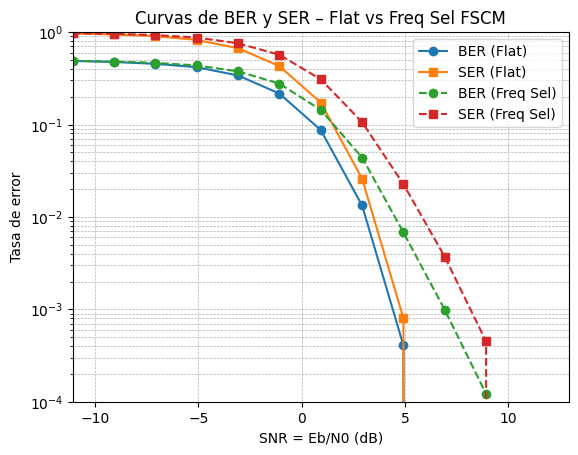

In [223]:
plt.figure()

plt.semilogy(EbN0_dB_range, BER_awgn,    'o-', label='BER (Flat)')
plt.semilogy(EbN0_dB_range, SER_awgn,    's-', label='SER (Flat)')
plt.semilogy(EbN0_dB_range, BER_freqsel, 'o--',label='BER (Freq Sel)')
plt.semilogy(EbN0_dB_range, SER_freqsel, 's--',label='SER (Freq Sel)')

plt.ylim(1e-4, 1)

plt.xlim(EbN0_dB_range[0], EbN0_dB_range[-1])   # -9 … +11 dB

plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlabel('SNR = Eb/N0 (dB)')
plt.ylabel('Tasa de error')
plt.title('Curvas de BER y SER – Flat vs Freq Sel FSCM')
plt.legend()
plt.show()
